Please find torch implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/13/multi_gpu_training_torch.ipynb

#Train a CNN on multiple GPUs using data parallelism.

Based on sec 12.5 of http://d2l.ai/chapter_computational-performance/multiple-gpus.html.

Since writing JAX requires a completely different mindset from that of PyTorch, translating the notebook work-by-word would inevitably lead to JAX code with a PyTorch "accent". To avoid that, I created an idiomatic JAX/Flax implementation of multi-device training from scratch. It borrows some code from the official [Parallel Evaluation in JAX](https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html) notebook (which trains a linear regression model), and follows roughly the same narration as [the original D2L notebook](https://github.com/probml/probml-notebooks/blob/main/notebooks-d2l/multi_gpu_training_torch.ipynb).


## Preparation

Not everyone can enjoy the luxury of a TPU runtime on CoLab, and the GPU runtime only provides one GPU instance, so we are going to stick with a humble CPU runtime to make the notebook more accessible. When JAX is running on CPU, we can emulate an arbitrary number of devices with an XLA flag. Of course, this is for illustration purposes only, and won't make your code run any faster.

In [2]:
import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import jax
import jax.numpy as jnp  # JAX NumPy

try:
    import flax
except ModuleNotFoundError:
    %pip install -qq flax
    import flax
from flax import linen as nn  # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

try:
    import optax  # Optimizers
except ModuleNotFoundError:
    %pip install -qq optax
    import optax  # Optimizers
try:
    import tensorflow_datasets as tfds  # TFDS for Fashion MNIST
except ModuleNotFoundError:
    %pip install -qq tensorflow tensorflow_datasets
    import tensorflow_datasets as tfds  # TFDS for Fashion MNIST

import os
import functools
from typing import Tuple

Now we have 8 devices

In [4]:
jax.devices()

[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7)]

## Model

We use the CNN from the [Flax README](https://github.com/google/flax#what-does-flax-look-like) as a demonstration. Training with multiple device does not require any change to the model, so you can replace it with your favourite network, as long as it outputs a 10-width logit for each input instance.

In [5]:
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.log_softmax(x)
        return x

## Data loading

We load the Fashion MNIST dataset with TFDS.

In [6]:
def get_datasets(split):
    """Load MNIST train/test dataset into memory."""
    ds_builder = tfds.builder("fashion_mnist")
    ds_builder.download_and_prepare()
    ds = tfds.as_numpy(ds_builder.as_dataset(split=split, batch_size=-1))
    x = jnp.array(ds["image"] / 255.0)
    y = jnp.array(ds["label"])
    return x, y


train_x, train_y = get_datasets("train")

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Note that TFDS uses the NHWC format, which mean "channel" dimension is the last axis. This is different from the NCHW format used by other data loaders, e.g. `torchvision.datasets.FashionMNIST`.

In [7]:
assert train_x.shape == (60000, 28, 28, 1)
assert train_y.shape == (60000,)

We split the training set into mini-batches of 256 instances, so that each of the 8 devices will handle 32 instances within each batch. Note that the "total batch size" must be divisible by the number of devices. However, it is okay if the number of training instances cannot be evenly divided by the total batch size (256). While one can handle the leftover with a bit more work, we skip the incomplete batches for simplicity.

In [8]:
total_batch_size = 256
n_devices = jax.local_device_count()
local_batch_size = total_batch_size // n_devices
assert local_batch_size * n_devices == total_batch_size

device_total = local_batch_size * n_devices
train_x = train_x[: len(train_x) // device_total * device_total]
train_y = train_y[: len(train_y) // device_total * device_total]

train_x = train_x.reshape(-1, local_batch_size, 28, 28, 1)
train_y = train_y.reshape(-1, local_batch_size)

We are going to use `jax.pmap`, which requires us to manually distribute data across the devices. More specifically, we need to transform both the images and their labels to the shape `[batch_per_device, num_devices, batch_size, ...]`. That way, the leading dimension of each "local batch" will be equal to `num_devices`.

In [9]:
def split(arr):
    """Splits the first axis of `arr` evenly across the number of devices."""
    return arr.reshape(arr.shape[0] // n_devices, n_devices, *arr.shape[1:])


train_x = split(train_x)
train_y = split(train_y)

To clarify, we have 8 devices, each of which will handle 234 local batches of 32 instances.

In [10]:
assert train_x.shape == (234, n_devices, local_batch_size, 28, 28, 1)
assert train_y.shape == (234, n_devices, local_batch_size)

## Parallel training

Parallel training with JAX is as simple as decorating the `update` function with `jax.pmap` and synchronising gradients across devices with `jax.lax.pmean`. See the comments for more details.

In [11]:
def create_train_state(rng, learning_rate):
    """Creates initial `TrainState`."""
    cnn = CNN()
    params = cnn.init(rng, jnp.ones((1, 28, 28, 1)))["params"]
    tx = optax.adam(learning_rate)
    state = train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)
    return state

In [12]:
def loss_fn(params, xs, ys):
    logits = CNN().apply({"params": params}, xs)
    one_hot = jax.nn.one_hot(ys, num_classes=10)
    loss = jnp.sum(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    return loss

In [13]:
@functools.partial(jax.pmap, axis_name="batch")
def update(
    state: train_state.TrainState, xs: jnp.ndarray, ys: jnp.ndarray
) -> Tuple[train_state.TrainState, jnp.ndarray]:
    """Performs one update step on params using the given data."""
    # Compute the gradients on the given minibatch (individually on each device).
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, xs, ys)

    # Combine the gradient across all devices (by taking their mean).
    grads = jax.lax.pmean(grads, axis_name="batch")

    # Also combine the loss. Unnecessary for the update, but useful for logging.
    loss = jax.lax.pmean(loss, axis_name="batch")

    # Each device performs its own update, but since we start with the same params
    # and synchronise gradients, the params stay in sync.
    state = state.apply_gradients(grads=grads)

    return state, loss

We are *summing* the gradient within a batch, and *averaging* it across devices. You need to keep this fact in mind when choosing the learning rate.

In [14]:
# Initialise parameters
rng = jax.random.PRNGKey(42)
rng, init_rng = jax.random.split(rng)
learning_rate = 0.2
state = create_train_state(init_rng, learning_rate)
del init_rng  # Must not be used anymore.

# Learning curve

The traing loop mostly stays the same. Note that we need to replicate the parameters across all devices when creating the train state, and remove that extra leading dimension when the training is done.

In [15]:
num_epochs = 5

# Replicate across devices.
replicated_states = flax.jax_utils.replicate(state)

# Actual training loop.
losses = []
for i in range(num_epochs):
    loss = 0
    for batch_x, batch_y in zip(train_x, train_y):
        # This is where the params and data gets communicated to devices:
        replicated_states, batch_loss = update(replicated_states, batch_x, batch_y)

        # Note that loss is actually an array of shape [num_devices], with identical
        # entries, because each device returns its copy of the loss, so we need
        # to unreplicate it.
        loss += flax.jax_utils.unreplicate(batch_loss)

    losses.append(loss)
    print(f"Step {i:3d}, loss: {loss:.3f}")

state = flax.jax_utils.unreplicate(replicated_states)

Step   0, loss: 297723.250
Step   1, loss: 4534.677
Step   2, loss: 3913.025
Step   3, loss: 3867.223
Step   4, loss: 3580.433


We ignore the first item in `losses`, which represents the initial loss of the randomly-initalized parameter.

Text(0, 0.5, 'Training Loss')

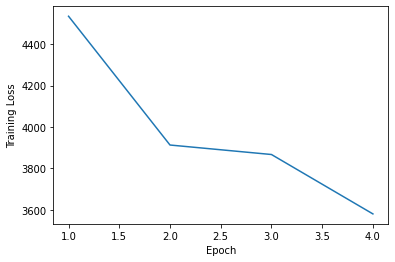

In [16]:
plt.plot(range(1, num_epochs), losses[1:])
plt.xlabel("Epoch")
plt.ylabel("Training Loss")

## Evaluation

We can evaluate the model on the test set as usual. The performance is not bad given that we only trained for 5 epoches.

In [17]:
def evaluate(state, xs):
    logits = CNN().apply({"params": state.params}, xs)
    prediction = jnp.argmax(logits, -1)
    return prediction

In [18]:
test_x, test_y = get_datasets("test")
print(evaluate(state, test_x[:10, :]))
print(test_y[:10])

[4 4 9 9 5 1 0 5 7 4]
[4 4 9 7 5 1 0 5 7 4]


In [19]:
np.mean(evaluate(state, test_x) == test_y)

DeviceArray(0.8086, dtype=float32)